## PINN Solver: Simple 2D Poisson Equation

Consider a 2D Poisson's equation with Dirichlet boundary conditions:
\begin{eqnarray*}
    \Delta u(x, y) = f(x, y),& \quad& \text { in } \Omega:=(0, 1) \times (0, 1), \\
    u(x, y) = g(x, y),& \quad&  \text { on } \partial \Omega,
\end{eqnarray*}
where $\Delta$ is the Laplacian operator, $f(x) = 5$, and $g(x, y) = 1$.

(1)
Approximate the solution using the residual model that we discussed in class. Helper functions and the network set-up is given. Your only task is to complete the traininig process. **You can complete this part in Google Colab if you do not have cuda-compatible GPUs or do not have Pytorch with cuda installed.**

Graph the final solution (heatmap, contour plot, or 3D plot, whichever is fine).

> Example Steps:
1. Use a feedforward neural network (fully connected network) to approximate the solution $u(x, y)$.
2. Sample Points in the domain and on the boundary, respectively.
3. Calculate the Laplacian $\Delta u(x, y)$ (second derivatives with respect to $x$ and $y$ ) using automatic differentiation.
4. Define the loss function. The residual loss: LosSpDE, which enforces $\Delta u(x, y)=f(x, y)$ inside the domain. The boundary loss: $\operatorname{Loss}_{\mathrm{BC}}$, which ensures the boundary condition $u(x, y)=g(x, y)$ is satisfied on $\partial \Omega$.
  - $\operatorname{LossPDE~}=\frac{1}{N_{\text {int }}} \sum_{i=1}^{N_{\text {int }}}\left(\Delta u\left(x_i, y_i\right)-f\left(x_i, y_i\right)\right)^2$
  - $\operatorname{Loss}_{\mathrm{BC}}=\frac{1}{N_{\mathrm{bc}}} \sum_{i=1}^{N_{\mathrm{bc}}}\left(u\left(x_i, y_i\right)-g\left(x_i, y_i\right)\right)^2$
5. Training the model to minimize the total loss, which is a combination of the residual and boundary losses.


(2)
Approximate the solution using Finite Difference Method with a grid-size $n =100$. The resulting linear system of equations $Au =b$ should be solved via Jacobi Method initialized with all 0s. The stoping criteria for Jacobi method is when $|u_{i,j}^{k+1} - u_{i,j}^{k}| < \epsilon,~ \forall i,j$. Use $\epsilon = 10e-7$. (i.e., the difference between the updated values and the old values are small).

Graph the final solution (heatmap, contour plot, or 3D plot, whichever is fine).

> Example Steps:
1. The unit square domain can be discretized as an $N \times N$ grid:
$$x_i = i\cdot h,~ y_j = j\cdot h,~i, j \in[0, N],$$
where the step size $h = dx = dy = \frac{1}{N}$, and
$$u_{i, j}=u\left(x_i, y_j\right), ~f_{i, j}=f\left(x_i, y_j\right) = 5.$$
2. By central difference approximation:
$$\frac{u_{i+1, j}+u_{i-1, j}-2 u_{i, j}}{h^2}+\frac{u_{i, j+1}+u_{i, j-1}-2 u_{i, j}}{h^2}=5$$.
3. For all unknown $u_{i,j}, i, j \in[1, N-1]$, we have a system of $(N-2)^2$ equations with $(N-2)^2$ unknown variables, which can be written in the form of $Au = b$.
4. Solve the algebraic system numerical methods (Jacobi for this assignment).
5. The element-based Jacobi updating formula for $u_i$ is:
$$
u_i^{(k+1)}=\frac{1}{a_{i i}}\left(b_i-\sum_{j \neq i} a_{i j} u_j^{(k)}\right), \quad i=1,2, \ldots, n .
$$

Hint: The update rule for every grid point in the domain is the same so that you don't actually have to flatten $u$ and $b$ and construct the matrix $A$ although it is also okay to do so.

Hint: The update rule for every grid point in the domain is the same so that you don't actually have to flatten $u$ and $b$ and construct the matrix $A$ although it is also okay to do so.

## Part (1) Solve by PINN

### Given Code

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim, autograd, tanh, Tensor
import numpy as np
from numpy import zeros, sum, sqrt, linspace, absolute
from torch.nn.functional import relu
import matplotlib.pyplot as plt

############################# Given #####################################
torch.set_default_tensor_type('torch.cuda.DoubleTensor')
torch.manual_seed(595)
np.random.seed(595)

class FNN(torch.nn.Module):
    def __init__(self, m):
        super(FNN, self).__init__()
        self.layer1 = nn.Linear(2, m)
        self.layer2 = nn.Linear(m, m)
        self.layer3 = nn.Linear(m, 1)
        self.activation = lambda x: tanh(x)

    def forward(self, tensor_x_batch):
        y = self.layer1(tensor_x_batch)
        y = self.layer2(self.activation(y))
        y = self.layer3(self.activation(y))
        y = y.squeeze(0)
        return y


def generate_points_in_the_domain(N_1): # returns N_1 random points in the domain
    return torch.rand(N_1, 2)


def generate_points_on_the_boundary(N_2): # returns N_2 random points on the boundary
    num = -(-N_2//4)  # get ceil of N_2/4, but in general, we assume N_2 divisible by 4
    zero_to_one = torch.rand(num, 1)
    # x1-x4 for 4 sides of the square, each num points
    x1 = torch.cat((zero_to_one, torch.zeros_like(zero_to_one)), dim=1)
    x2 = torch.cat((zero_to_one, torch.ones_like(zero_to_one)), dim=1)
    x3 = torch.cat((torch.ones_like(zero_to_one), zero_to_one ), dim=1)
    x4 = torch.cat((torch.zeros_like(zero_to_one), zero_to_one ), dim=1)
    x = torch.cat((x1, x2, x3, x4), dim=0)
    return x

# calculate nabla u
def gradients(output, intput):
  # doutput/dintput (do/di)
  # For example, if the output is f(x,y) the intput is (x,y), the return will be the gradients [f paritial x, f partial y]
    return autograd.grad(outputs=output, inputs=input,
                                grad_outputs=torch.ones_like(output),
                                create_graph=True, retain_graph=True, only_inputs=True)[0]

# some hyper-parameters
n_epoch = 30000 # number of epochs  approximately 0.024 sec per epoch
N_1 = 1024  # number of training points in the interior
N_2 = 1024  # number of training points on the boundary, better divisible by 2^2 = 4
m = 30  # number of nodes in each layer for the basic and error sampling
lr = 5e-3  # learning rates
lambda_term = 1000  # boundary weighting term

# set up the NN and optimizer
model = FNN(m)
optimizer = optim.Adam(model.parameters(), lr=lr)
StepLR = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.99)

########################## You task starts here ################################
for epoch in range(n_epoch):
    # in each epoch, generate random N1 N2 points in the domain and on the boundary respectively




    # these points require grad: _.requires_grad_()


    # get the network prediction on these points



    # use auto grad to calculate the partial derivatives
    # first use the gradients functino above to get ux and uy,
    # then do slicing to differentiate ux with respect to only x, uy with respect to only y



    # Define the loss function in domain and on boundary,


    # total loss is the sum of these two loss terms

    ##################### Given ################################################
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    StepLR.step()
    if epoch % 3000 == 0:
         print('epoch:', epoch, 'loss:', loss.item(),"\n")



# plot the solution
x = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, x)  # X, Y grid
positions = np.vstack([X.ravel(), Y.ravel()]).T
net_solution = model(Tensor(positions))
net_sol = net_solution.cpu().detach().numpy()

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:749: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:431.)
  _C._set_default_tensor_type(t)


NameError: name 'loss' is not defined

###Solution:

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim, autograd, tanh, Tensor
import numpy as np
from numpy import zeros, sum, sqrt, linspace, absolute
from torch.nn.functional import relu
import matplotlib.pyplot as plt

torch.set_default_tensor_type('torch.cuda.DoubleTensor')
torch.manual_seed(553)
np.random.seed(553)

class FNN(torch.nn.Module):
    def __init__(self, m):
        super(FNN, self).__init__()
        self.layer1 = nn.Linear(2, m)
        self.layer2 = nn.Linear(m, m)
        self.layer3 = nn.Linear(m, 1)
        self.activation = lambda x: tanh(x)

    def forward(self, tensor_x_batch):
        y = self.layer1(tensor_x_batch)
        y = self.layer2(self.activation(y))
        y = self.layer3(self.activation(y))
        y = y.squeeze(0)
        return y

def get_testing_points():
    y_coor = np.arange(0.01, 1, 0.01)
    x_test_np = np.array([[x0, y0] for x0 in y_coor for y0 in y_coor])
    x_test = Tensor(x_test_np)
    x_test.requires_grad = False
    return x_test

def generate_points_in_the_domain(N_1):
    return torch.rand(N_1, 2)

def generate_points_on_the_boundary(N_2):
    num = -(-N_2//4)  # get ceil of N_2/4,
    zero_to_one = torch.rand(num, 1)
    # x1-x4 for 4 sides of the square, each num points
    x1 = torch.cat((zero_to_one, torch.zeros_like(zero_to_one)), dim=1)
    x2 = torch.cat((zero_to_one, torch.ones_like(zero_to_one)), dim=1)
    x3 = torch.cat((torch.ones_like(zero_to_one), zero_to_one ), dim=1)
    x4 = torch.cat((torch.zeros_like(zero_to_one), zero_to_one ), dim=1)
    x = torch.cat((x1, x2, x3, x4), dim=0)
    return x

# calculate nabla u
def gradients(output, input):
    return autograd.grad(outputs=output, inputs=input,
                                grad_outputs=torch.ones_like(output),
                                create_graph=True, retain_graph=True, only_inputs=True)[0]



# some hyper-parameters
n_epoch = 30001 # number of epochs  approximately 0.024 sec per epoch
N_1 = 1024  # number of training points in the interior
N_2 = 1024  # number of training points on the boundary, better divisible by 2^2 = 4

m = 30  # number of nodes in each layer for the basic and error sampling
d = 2  # dimension of the problem, which should be 2, do not change
lr = 3e-3  # learning rates
lambda_term = 1000  # boundary weighting term

model = FNN(m)
# model.apply(weights_init)
optimizer = optim.Adam(model.parameters(), lr=lr)
StepLR = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.99)
for epoch in range(n_epoch):
    # 1 for interior and 2 for boundary
    x_1 = generate_points_in_the_domain(N_1)
    x_2 = generate_points_on_the_boundary(N_2)
    x_1.requires_grad_()
    x_2.requires_grad_()
    network_solution_1 = model(x_1)
    network_solution_2 = model(x_2)
    # get the partial derivatives
    nabla = gradients(network_solution_1, x_1)
    # uxx + uyy
    delta = gradients(nabla[:, 0],x_1)[:, 0] + gradients(nabla[:, 1], x_1)[:, 1]
    loss_1 = torch.mean(torch.square(delta - 5))
    loss_2 = lambda_term * torch.mean(torch.square(network_solution_2 - 1))
    loss = loss_1 + loss_2
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    StepLR.step()
    if epoch % 3000 == 0:
         print('epoch:', epoch, 'loss:', loss.item(),"\n")

x = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, x)  # X, Y grid
positions = np.vstack([X.ravel(), Y.ravel()]).T
net_solution = model(Tensor(positions))
net_sol = net_solution.cpu().detach().numpy()

epoch: 0 loss: 1215.4577045713825 

epoch: 3000 loss: 0.7967466585502294 

epoch: 6000 loss: 0.3095500484461483 

epoch: 9000 loss: 0.2043029740180931 

epoch: 12000 loss: 0.1526829745893628 

epoch: 15000 loss: 0.14269530534414537 

epoch: 18000 loss: 0.13868785533645056 

epoch: 21000 loss: 0.1284479044082428 

epoch: 24000 loss: 0.13116926733248382 

epoch: 27000 loss: 0.129920373169695 

epoch: 30000 loss: 0.13169071844070093 



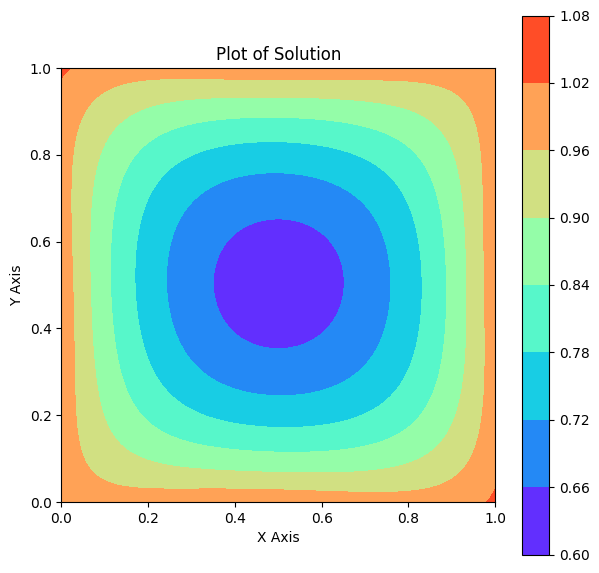

In [ ]:
plt.figure(figsize=(7,7))
plot = plt.contourf(X,Y, net_sol.reshape((100,100)), cmap='rainbow')
plt.gca().set_aspect('equal')
plt.title('Plot of Solution')
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plot.set_clim(0.6,1.1)
plt.colorbar()


## Part (2) Solve by FDM to compare solutions

### Given Code

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

### Solution

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def jacobi(grid, f, dx):
  # update rules
    newgrid = np.ones(shape=grid.shape)

    # apply evolution operator
    newgrid[1:-1,1:-1] = 0.25 * (grid[1:-1,:-2] + grid[1:-1,2:] +
                                 grid[:-2,1:-1] + grid[2:,1:-1] - f[1:-1,1:-1]*dx**2)


    return newgrid


def initgrid(gridsize):
  # initialize the solution grid
    u = np.zeros((gridsize,gridsize))
    # boundary condition
    u[0,:]  = 1
    u[:,-1] = 1
    u[-1,:] = 1
    u[:,0]  = 1

    return u


n = 100  # grid-size
u = initgrid(n)   # initial grid, n by n np array
L = 1.0    # square bdy length
dx = L/(n-1)   # FDM step size
x = np.linspace(0, L, n)
X, Y = np.meshgrid(x, x)  # X, Y grid
f = 5*np.ones((n,n))   # RHS values, n by n np array
epsilon = 1e-7
iter = 0

while True:
    if iter % 500 ==0:
        u_old = u
    u = jacobi(u, f, dx)
    # check this condition every 500 iterations
    if iter % 500 == 0:
        diff = np.absolute(u_old - u).max()
        if diff < epsilon:
            break
    iter = iter + 1

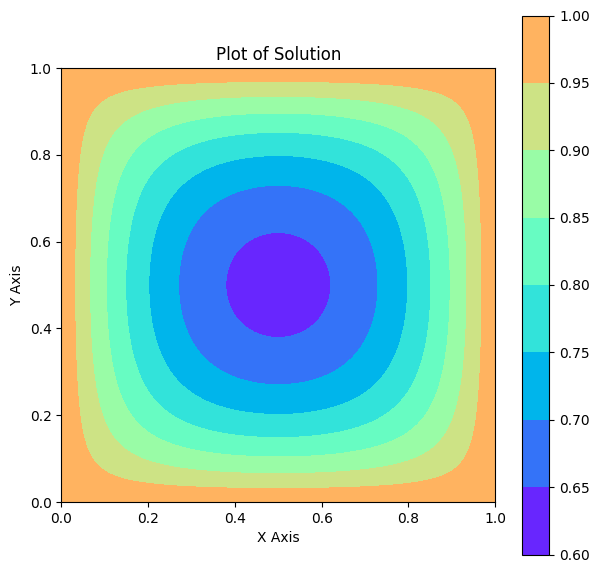

In [ ]:
plt.figure(figsize=(7,7))
plot = plt.contourf(X, Y, u,  cmap='rainbow')
plt.gca().set_aspect('equal')
plt.title('Plot of Solution')
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plot.set_clim(0.6,1.1)
plt.colorbar()